# 라이언얼굴 바꿔치기 - advanced
1회차 놀이터 미팅 중, 팀원 한분이 라이언 고개기울기도 고려해보고 싶단 아이디어가 있었음. 이를 랜드마크 점들을 이용한 기울기로 해결하면 될것 같아서 적용해봄

### 진행사항
* cv2.flip()을 이용하여 좌우 대칭 반전
* 코의 28번과 턱의 9번을 이용하면 얼굴의 기울기를 확인할 수 있을 것임.
* 기울기 + 삼각함수를 이용한 각도계산 
* imutils.rotate()를 이용한 라이언이미지 각도변환

참고: https://enjoyimageprocessing.tistory.com/entry/OpenCV%EC%9D%98-%EA%B8%B0%EC%B4%88-Image-ProcessingTransition-Rotation

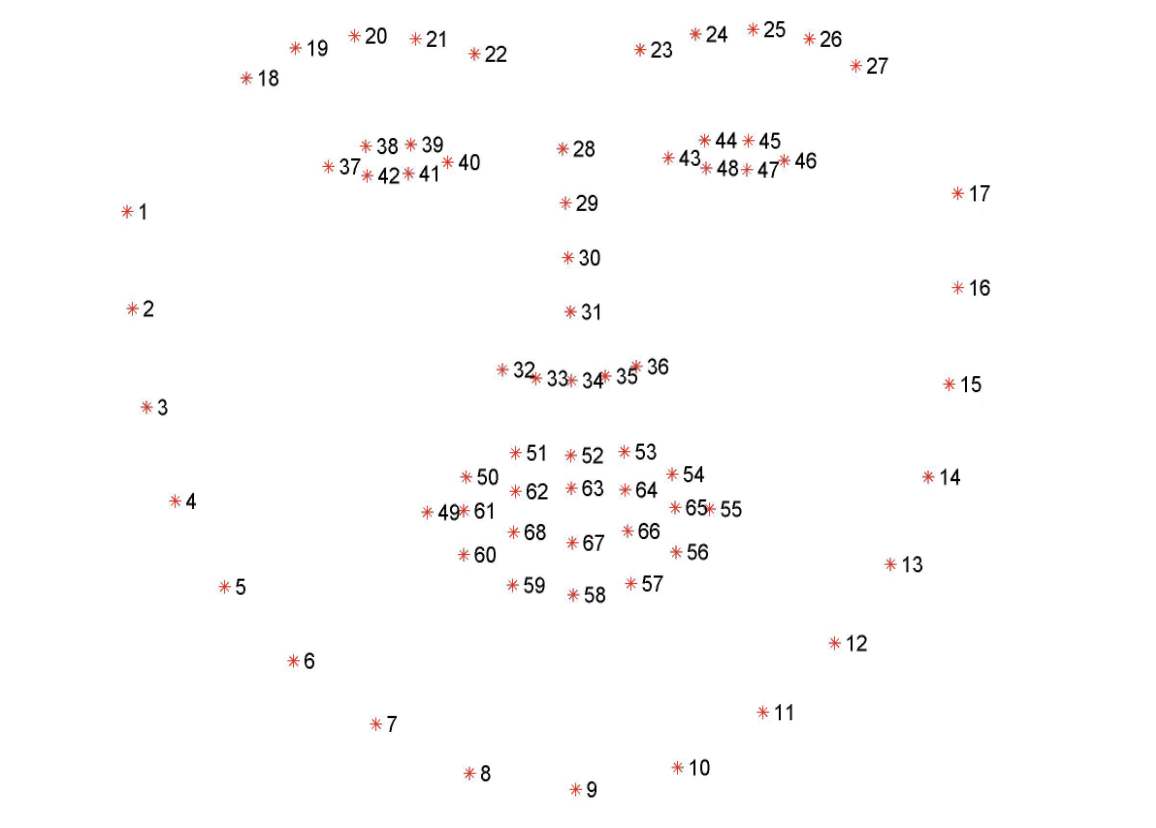

In [14]:
import cv2, dlib, sys
import numpy as np

## 3. 라이언얼굴로 바꾸기
overlay_transparent란 사용자정의함수 만들어 동영상에 정적 img overlay

In [15]:
# overlay function
def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
  bg_img = background_img.copy()
  # convert 3 channels to 4 channels
  if bg_img.shape[2] == 3:
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

  if overlay_size is not None:
    img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

  b, g, r, a = cv2.split(img_to_overlay_t)

  mask = cv2.medianBlur(a, 5)

  h, w, _ = img_to_overlay_t.shape
  roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]

  img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
  img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

  bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

  # convert 4 channels to 4 channels
  bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)

  return bg_img

In [16]:
import imutils
# resize (이미지 크기를 줄임)
scaler = 0.3

# initialize face detector and shape predictor
detector = dlib.get_frontal_face_detector()  # 얼굴 디텍터 모듈 초기화
# shape_pred.dat은 머신러닝으로 학습된 모델 
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')  # 얼굴 특징점 모듈 초기화

# load video(동영상 파일 로드)
# VideoCapture(0) - 파일 이름대신 0을 넣으면 웹캠
# cap = cv2.VideoCapture('girl.mp4')
cap = cv2.VideoCapture(0)


# load overlay image(라이언 이미지)
overlay = cv2.imread('ryan_transparent.png', cv2.IMREAD_UNCHANGED) # 알파채널까지 함께 읽어야 함.(투명)
# print(type(overlay), overlay.shape)    # <class 'numpy.ndarray'> (130, 129, 4) (h, w, c) 알파채널 포함 4


while True:
    # read frame buffer from video
    ret, img = cap.read()
    if not ret:
        break
    
    # resize frame
    # resize(img, dsize) 크기 조절(꼭 정수형으로 값을 받아야함)
    img = cv2.flip(img, 1) 
    img = cv2.resize(img, (int(img.shape[1] * scaler), int(img.shape[0] * scaler)))
    ori = img.copy()
    
    # 얼굴 찾기
    faces = detector(img)
    try:
        face = faces[0]  # 여러얼굴이 나오니까 첫번째 얼굴만
    except:
        next
    
    # 얼굴 특징점(facial landmark) 찾기
    dlib_shape = predictor(img, face)
    shape_2d = np.array([[p.x, p.y] for p in dlib_shape.parts()])  # dlib 객체를 np로 변환
    
    ###################### [Test 얼굴 기울기 구하기] ############
    # 코 최상단 x, y좌표
    top = shape_2d[27, :]
    down = shape_2d[8, :]
    
    img = cv2.line(img, pt1=top, pt2=down,
                  color=(0,255,0), thickness=2)
    fc_slope = (down[1] - top[1]) / (down[0] - top[0]) 
    angle_rad = np.arctan(fc_slope) #x의 arctan값 구하기 / 구하면 radian값이 나옵니다.
    angle = np.degrees(angle_rad)   #radian값을 degree값으로 바꿔줍니다.

    if angle < 0:  # 시계반대방향 회전은 + 시계방향 회전은 -가 되게끔
        angle = -(90 + angle)  # -로 만들어 시계방향 회전
    else:
        angle = 90 - angle  # +로 만들어 시계반대방향 회전
#     print(angle)
    
    
    # 라이언에 적용하기
    overlay_copy = imutils.rotate(overlay, angle)

    ###################### [Test END] ############
    
    
    # 얻은 특징점으로 얼굴 size구하기(좌표 구하기)
    # 좌상단 우하단
    top_left = np.min(shape_2d, axis=0)
    bottom_right = np.max(shape_2d, axis=0)
#     print(top_left, bottom_right)      # [246  84] [328 172]
    
    # compute face size
    # 우하단에서 좌상단뺀 x, y길이의 가장 긴 값
    face_size = max(bottom_right - top_left)     # 82 88
#     print(face_size)
    # 라이언 얼굴 사이즈를 키우기 위해 1.8배 
    face_size = int(np.mean(face_size) * 1.8)
#     print(face_size)
    
    # compute face center
    # 랜드마크로 얼굴의 중심(좌표 구하기)
    # 모든 특징점의 평균을 구하여 얼굴 중심을 구함, 정수형으로 변환필요
    center_x, center_y = np.mean(shape_2d, axis=0).astype(np.int)
    
    # draw overlay on face
    # 라이언이미지를 센터x, y를 중심으로 넣고 overlay사이즈(얼굴의 가로세로중 가장큰 크기)만큼 resize해서 원본이미지에 넣어줌
    result = overlay_transparent(ori, overlay_copy, 
                                 center_x + 8, center_y - 25, 
                                 overlay_size=(face_size, face_size))
    
    
    # draw
    # rectangle(img, 좌상단좌표, 우하단 좌표)
    img = cv2.rectangle(img, 
                        pt1=(face.left(), face.top()),
                        pt2=(face.right(), face.bottom()),
                        color=(255, 255, 255), # 흰색
                        thickness=2,
                        lineType=cv2.LINE_AA
                       )
    # 랜드마크를 원으로 표시
    for s in shape_2d:
        cv2.circle(img, center=tuple(s), radius=1, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)

    # 랜드마크의 좌상단 우하단 크기 그리기
    cv2.circle(img, center=tuple(top_left), radius=1, color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
    cv2.circle(img, center=tuple(bottom_right), radius=1, color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
    cv2.circle(img, center=(center_x, center_y), radius=1, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)


    # visualize
    cv2.imshow('img', img)    # 윈도우 이름과 이미지 파일
    cv2.imshow('result', result)  # 라이언 이미지 오버랩 이미지
    if cv2.waitKey(1) == ord('q'):
        break

/var/folders/_y/3g1htll97v36y_h0zv82ssr00000gn/T/ipykernel_62927/1891823245.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  center_x, center_y = np.mean(shape_2d, axis=0).astype(np.int)
/var/folders/_y/3g1htll97v36y_h0zv82ssr00000gn/T/ipykernel_62927/1891823245.py:51: RuntimeWarning: divide by zero encountered in long_scalars
  fc_slope = (down[1] - top[1]) / (down[0] - top[0])
